# Apache Beam - ParDo

The `ParDo` allows us to execute code element by element on a `PCollection`.  At the highest level, think of `ParDo` as a `PTransform`.  This means that we can use a `ParDo` as a pipline step:

```
PCollection myPcollection = ...;
myPcollection.apply("Perform Pardo", ParDo.of(...));
```

When we create an instance of a `ParDo`, we need to pass in a Class that extends `DoFn`.  This class contains a method called `processElement` that is called *once* for each element found in the `PCollection`.  During execution, the `processElement` method will add zero, one or more elements into an output `PCollection` which will be the output `PCollection` of the `ParDo` transform itself.

The `processElement` method is likely to have a signature of:

```
@ProcessElement
public void processElement(@Element inputT element, OutputReceiver<outputT> out) {
  ... code here
}
```

Each element in the input PCollection is passed into the method through the `element` parameter.  The `OutputReceiver` parameter has a method on it called `output` that allows us to propagate an output value.

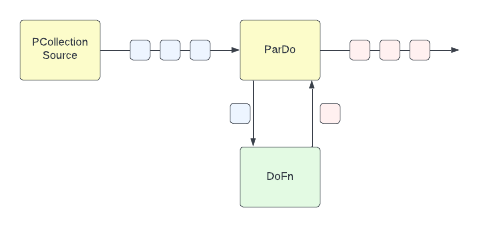


* [JavaDoc: Class ParDo](https://beam.apache.org/releases/javadoc/2.42.0/org/apache/beam/sdk/transforms/ParDo.html)
* [JavaDoc: Class DoFn](https://beam.apache.org/releases/javadoc/2.42.0/index.html?org/apache/beam/sdk/transforms/DoFn.html)

First, we define the dependencies that we wish to load from the Maven repositories.

In [1]:
%%loadFromPOM

<dependency>
  <groupId>org.apache.beam</groupId>
  <artifactId>beam-sdks-java-core</artifactId>
  <version>2.40.0</version>
</dependency>

<dependency>
  <groupId>org.apache.beam</groupId>
  <artifactId>beam-runners-direct-java</artifactId>
  <version>2.40.0</version>
  <scope>runtime</scope>
</dependency>

<dependency>
  <groupId>org.slf4j</groupId>
  <artifactId>slf4j-jdk14</artifactId>
  <version>2.0.6</version>
</dependency>

<dependency>
  <groupId>org.slf4j</groupId>
  <artifactId>slf4j-api</artifactId>
  <version>2.0.6</version>
</dependency>

Next we define our imports required for execution.

In [2]:
import java.util.Arrays;
import java.util.List;

import org.apache.beam.sdk.Pipeline;
import org.apache.beam.sdk.options.Default;
import org.apache.beam.sdk.options.Description;
import org.apache.beam.sdk.options.PipelineOptionsFactory;
import org.apache.beam.sdk.options.PipelineOptions;
import org.apache.beam.sdk.options.StreamingOptions;
import org.apache.beam.sdk.transforms.Create;
import org.apache.beam.sdk.values.PCollection;
import org.apache.beam.sdk.transforms.DoFn;
import org.apache.beam.sdk.transforms.ParDo;
import org.apache.beam.sdk.transforms.ProcessFunction;
import org.apache.beam.sdk.transforms.MapElements;
import org.apache.beam.sdk.values.TypeDescriptors;
import org.slf4j.Logger;
import org.slf4j.LoggerFactory;
import java.util.logging.Level;

String args[] = new String[] {};
var options = PipelineOptionsFactory.fromArgs(args).withValidation().create();

Now we define our `DoFn` that is going to be executed once per element.  In this example, we simply write the output to the output stream (console).

In [3]:
public class LoggingDoFn<T> extends DoFn<T, T>  {
  @ProcessElement
  public void processElement(@Element T element, OutputReceiver<T> out) {
    System.out.println(element);
    out.output(element);
  }
}

Finally, we run the pipeline and see the output:

In [4]:
var pipeline = Pipeline.create(options);
pipeline
  .apply("Create elements", Create.of(Arrays.asList("Hello!", "World!")))
  .apply("Print elements",ParDo.of(new LoggingDoFn<>()));
pipeline.run().waitUntilFinish();

Hello!
World!


DONE

## DoFn Lifecycle methods
We can further annotate a `DoFn` class with other lifecycle methods including:

* `@Setup` - Called once when the DoFn is initialized.
* `@StartBundle` - Called a the start of each bundle processed.
* `@FinishBundle` - Called when a bundle has been processed.
* `@Teardown` - Called when the work has finished (opposite of @Setup).


We will find that the `@Setup` is called first, next `@StartBundle`, next `@ProcessElement`, next `@FinishBundle`.  We may loop around `@StartBundle`, `@ProcessElement`, `@FinishBundle` before finally calling `@Teardown`.

It is important to realize that a `DoFn` instance may be reused when it has completed previous work.  As such, don't assume *default* state when it is created.  Set state in `@Setup` and `@StartBundle` as needed.

In [5]:
public class MyParDoFn extends DoFn<String, String> {

  private void logPipelineOptions(PipelineOptions options) {
    System.out.println("- jobName: " + options.getJobName());
    System.out.println("- optionsId: " + options.getOptionsId());      
  }
    
  // Setup function has no arguments
  @Setup
  public void setup() {
    System.out.println("Setup called! ThreadId: " +
      Thread.currentThread().getId() + ", ClassInstance: " + System.identityHashCode(this));
  }
  
  // Start Bundle has optional arguments of:
  // - StartBundleContext
  // - PipelineOptions
  // - BundleFinalizer
  @StartBundle
  public void startBundle(
    DoFn<String, String>.StartBundleContext context,
    PipelineOptions options) {
    System.out.println("StartBundle called! ThreadId: " +
      Thread.currentThread().getId() + ", ClassInstance: " + System.identityHashCode(this));
    //logPipelineOptions(options);      
  }
    
  @FinishBundle
  public void finishBundle() {
    System.out.println("finishBundle called! ThreadId: " +
      Thread.currentThread().getId() + ", ClassInstance: " + System.identityHashCode(this));
  }
  
  @Teardown
  public void teardown() {
    System.out.println("Teardown called! ThreadId: " +
      Thread.currentThread().getId() + ", ClassInstance: " + System.identityHashCode(this));
  }
  
  @ProcessElement
  public void processElement(@Element String word, OutputReceiver<String> out) {
    System.out.println(word);
    out.output(word);
  }
}

pipeline = Pipeline.create(options);
pipeline
  .apply("Create elements", Create.of(Arrays.asList("Hello!", "World!")))
  .apply("Print elements",ParDo.of(new MyParDoFn()));
pipeline.run().waitUntilFinish();

Setup called! ThreadId: 28, ClassInstance: 226874980
Setup called! ThreadId: 27, ClassInstance: 142669439
StartBundle called! ThreadId: 27, ClassInstance: 142669439
World!
StartBundle called! ThreadId: 28, ClassInstance: 226874980
finishBundle called! ThreadId: 27, ClassInstance: 142669439
Hello!
finishBundle called! ThreadId: 28, ClassInstance: 226874980
Teardown called! ThreadId: 26, ClassInstance: 226874980
Teardown called! ThreadId: 26, ClassInstance: 142669439


DONE

## MapElements
Similar to ParDo, there is a transform called [MapElements](https://beam.apache.org/releases/javadoc/2.42.0/org/apache/beam/sdk/transforms/MapElements.html).  MapElements has fewer options than ParDo but may be simpler to use.  We can create a [ProcessFunction](https://beam.apache.org/releases/javadoc/2.42.0/org/apache/beam/sdk/transforms/ProcessFunction.html) that takes an input element and returns an output element.

In [6]:
pipeline = Pipeline.create(options);
pipeline
  .apply("Create elements", Create.of(Arrays.asList("Hello!", "World!")))
  .apply("Upper case ", MapElements.into(TypeDescriptors.strings()).via(new ProcessFunction<String, String>() {
    public String apply(String text) throws Exception{
      return text.toUpperCase();
    }
  }))
  .apply("Print elements",ParDo.of(new LoggingDoFn<>()));
pipeline.run().waitUntilFinish();

HELLO!
WORLD!


DONE

Using the `ProcessFunction`, we can go one step further (if desired) and use a lambda function.  Whether this is more or less readable is going to be matter of taste.

In [7]:
pipeline = Pipeline.create(options);
pipeline
  .apply("Create elements", Create.of(Arrays.asList("Hello!", "World!")))
  .apply("Upper case ", MapElements.into(TypeDescriptors.strings()).via((String word)->word.toUpperCase()))
  .apply("Print elements",ParDo.of(new LoggingDoFn<>()));
pipeline.run().waitUntilFinish();

WORLD!
HELLO!


DONE

## Logging in your DoFn
Since a ParDo involves writing custom code, you might wish to consider adding log statements to aid in diagnostics.  Beam uses [SLF4J](https://www.slf4j.org/) as its logging interafce.  Since this is wrapper around another log provider, you will want to also specify which back-end logger to use.  I use `java.util.logging` which meant include the `slf4j-jdk14` JAR.

Getting SLF4J can JUL working can be a little tricky.  One working solution is to create a file called `jul-log.properties` which contains:

```
handlers= java.util.logging.ConsoleHandler
.level= FINEST
java.util.logging.ConsoleHandler.level = FINEST
java.util.logging.ConsoleHandler.formatter = java.util.logging.SimpleFormatter
java.util.logging.SimpleFormatter.format=[%1$tF %1$tT] [%4$s] [%3$s] %5$s %n
```

and then modifying the kernel.json file for IJava to include:

```
"-Djava.util.logging.config.file=/<path>/jul-log.properties",        
```

and restart the kernels.  The output will now show where you launched jupyter.

See also:
* [Docs: Work with pipeline logs](https://cloud.google.com/dataflow/docs/guides/logging)
* [JavaDoc: org.slf4j.LoggerFactory](https://www.slf4j.org/api/org/slf4j/LoggerFactory.html)
* [JavaDoc: org.slf4j.Logger](https://www.slf4j.org/api/org/slf4j/Logger.html)
* [Java Logging Overview](https://docs.oracle.com/javase/8/docs/technotes/guides/logging/overview.html)
* [Java Logging API - Tutorial](https://www.vogella.com/tutorials/Logging/article.html)
* java.util.logging.config.file - property

In [9]:
final Logger LOG = LoggerFactory.getLogger("test");

public class LoggingDoFn<T> extends DoFn<T, T>  {
  @ProcessElement
  public void processElement(@Element T element, OutputReceiver<T> out) {
    System.out.println(element);
    LOG.debug("debug: " + element);
    LOG.trace("trace: " + element);
    LOG.info("info: " + element);
    out.output(element);
  }
} // End of LoggingDoFn

var pipeline = Pipeline.create(options);
pipeline
  .apply("Create elements", Create.of(Arrays.asList("Hello!", "World!")))
  .apply("Print elements",ParDo.of(new LoggingDoFn<>()));
pipeline.run().waitUntilFinish();

Hello!
World!


DONE